# Teeth Segmentation Model Training

This notebook trains a U-Net model with a MobileNetV2 backbone on the DentalAI dataset for teeth segmentation.

## 1. Setup and Installations

In [1]:
# Install required packages
!pip install -q segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.5 MB/s eta 0:00:00:00:0100:01


In [ ]:
import os
import json
import warnings
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import segmentation_models_pytorch as smp

warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")


Using device: cuda
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: Tesla T4
CUDA memory: 14.7 GB


## 2. Configuration

In [ ]:
class CFG:
    DATASET_PATH = '/kaggle/input/dentalai-dataset'
    IMG_SIZE = 256
    BATCH_SIZE = 16
    EPOCHS = 25
    LEARNING_RATE = 1e-3
    ENCODER = 'mobilenet_v2'
    ENCODER_WEIGHTS = 'imagenet'
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    SEED = 42
    MODEL_SAVE_PATH = 'best_teeth_segmentation_model.pth'

# Set seeds for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(CFG.SEED)
print(f"Using device: {CFG.DEVICE}")

Using device: cuda


## 3. Download and Prepare Dataset

### Custom Dataset Class
This class will handle loading images and parsing the JSON annotations to create binary masks for our 'tooth' class.

In [ ]:
class TeethDataset(Dataset):
    def __init__(self, dataset_path, split='train', transform=None):
        self.image_dir = Path(dataset_path) / split / 'img'
        self.ann_dir = Path(dataset_path) / split / 'ann'
        self.transform = transform
        
        self.image_files = sorted([f for f in self.image_dir.glob('*.jpg')])
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        ann_path = self.ann_dir / (img_path.stem + '.jpg.json')
        
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = self.create_mask(ann_path, image.shape[:2])
        
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            
        return image, mask.unsqueeze(0) # Add channel dimension to mask

    def create_mask(self, ann_path, shape):
        mask = np.zeros(shape, dtype=np.float32)
        with open(ann_path, 'r') as f:
            data = json.load(f)
        
        for obj in data['objects']:
            class_title = obj.get('classTitle', '')
            if class_title == 'Tooth':
                points = np.array(obj['points']['exterior'], dtype=np.int32)
                cv2.fillPoly(mask, [points], 1) # Fill with 1 for tooth class
        return mask

### Data Augmentations
We use `albumentations` to create robust augmentations for the training set and simple resizing/normalization for the validation set.

In [5]:
def get_transforms(img_size):
    train_transform = A.Compose([
        A.Resize(img_size, img_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
    
    val_transform = A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
    
    return train_transform, val_transform

train_transform, val_transform = get_transforms(CFG.IMG_SIZE)

# Create Datasets and DataLoaders
train_dataset = TeethDataset(CFG.DATASET_PATH, split='train', transform=train_transform)
val_dataset = TeethDataset(CFG.DATASET_PATH, split='valid', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 1991
Validation samples: 254


### Verify Data Loading
It's crucial to visualize a sample to ensure the masks are being generated correctly before starting a long training run.

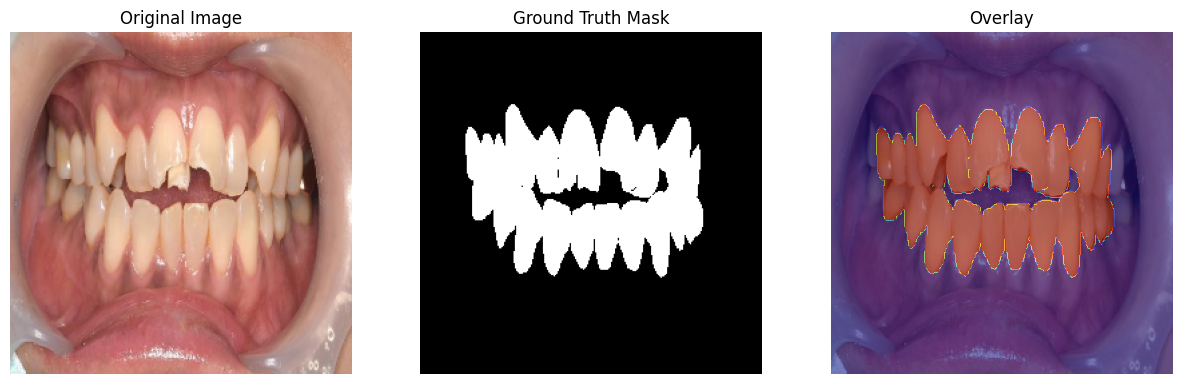

In [6]:
def show_sample(image, mask):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    # Denormalize image for display
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image.permute(1, 2, 0).numpy() * std + mean
    image = np.clip(image, 0, 1)
    
    mask = mask.squeeze().numpy()
    
    ax[0].imshow(image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Ground Truth Mask')
    ax[1].axis('off')
    
    ax[2].imshow(image)
    ax[2].imshow(mask, cmap='jet', alpha=0.5)
    ax[2].set_title('Overlay')
    ax[2].axis('off')
    
    plt.show()

image, mask = train_dataset[25] # Check a sample
show_sample(image, mask)

## 4. Model, Loss, and Optimizer

In [7]:
# Using the reliable smp library
model = smp.Unet(
    encoder_name=CFG.ENCODER,
    encoder_weights=CFG.ENCODER_WEIGHTS,
    in_channels=3,
    classes=1, # Output is a single binary mask
    activation=None # We want logits for BCEWithLogitsLoss
)
if torch.cuda.device_count() > 1:
  print(f"Using {torch.cuda.device_count()} GPUs!")
  model = nn.DataParallel(model)

model.to(CFG.DEVICE)

# Corrected, numerically stable loss function
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # comment out if your model contains a sigmoid or equivalent activation layer
        inputs_prob = torch.sigmoid(inputs)
        
        # flatten label and prediction tensors
        inputs_flat = inputs_prob.view(-1)
        targets_flat = targets.view(-1)
        
        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - ((2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth))
        bce = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        
        return bce + dice_loss

# Intersection over Union (IoU) metric
def iou_score(outputs, labels):
    outputs = torch.sigmoid(outputs) > 0.5
    labels = labels > 0.5
    intersection = (outputs & labels).float().sum((1, 2, 3))
    union = (outputs | labels).float().sum((1, 2, 3))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()

# Setup optimizer and scheduler
criterion = DiceBCELoss()
optimizer = optim.AdamW(model.parameters(), lr=CFG.LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

Using 2 GPUs!


## 5. Training and Validation Loop

In [8]:
def train_one_epoch(loader, model, optimizer, criterion, device):
    model.train()
    loop = tqdm(loader, desc="Training")
    running_loss = 0.0
    
    for images, masks in loop:
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())
        
    return running_loss / len(loader)

def validate_one_epoch(loader, model, criterion, device):
    model.eval()
    loop = tqdm(loader, desc="Validation")
    val_loss = 0.0
    val_iou = 0.0
    
    with torch.no_grad():
        for images, masks in loop:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            iou = iou_score(outputs, masks)
            
            val_loss += loss.item()
            val_iou += iou.item()
            loop.set_postfix(iou=iou.item())
            
    return val_loss / len(loader), val_iou / len(loader)

### Main Training Loop
This loop will train the model, evaluate it on the validation set after each epoch, and save the best performing model based on validation IoU.

In [9]:
best_val_iou = 0.0
history = {'train_loss': [], 'val_loss': [], 'val_iou': []}

for epoch in range(CFG.EPOCHS):
    print(f"--- Epoch {epoch+1}/{CFG.EPOCHS} ---")
    
    train_loss = train_one_epoch(train_loader, model, optimizer, criterion, CFG.DEVICE)
    val_loss, val_iou = validate_one_epoch(val_loader, model, criterion, CFG.DEVICE)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_iou'].append(val_iou)
    
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f}")
    
    # Update learning rate
    scheduler.step(val_iou)
    
    # Save the best model
    if val_iou > best_val_iou:
        print(f"Validation IoU improved from {best_val_iou:.4f} to {val_iou:.4f}. Saving model!")
        best_val_iou = val_iou
        torch.save(model.state_dict(), CFG.MODEL_SAVE_PATH)

print("\n🎉 Training Complete!")
print(f"Best Validation IoU: {best_val_iou:.4f}")
print(f"Model saved to: {CFG.MODEL_SAVE_PATH}")

--- Epoch 1/25 ---


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s, iou=0.807]


Epoch 1 | Train Loss: 0.4229 | Val Loss: 0.2539 | Val IoU: 0.7848
Validation IoU improved from 0.0000 to 0.7848. Saving model!
--- Epoch 2/25 ---


Validation: 100%|██████████| 16/16 [00:11<00:00,  1.38it/s, iou=0.802]


Epoch 2 | Train Loss: 0.2591 | Val Loss: 0.2378 | Val IoU: 0.7899
Validation IoU improved from 0.7848 to 0.7899. Saving model!
--- Epoch 3/25 ---


Validation: 100%|██████████| 16/16 [00:11<00:00,  1.36it/s, iou=0.822]


Epoch 3 | Train Loss: 0.2314 | Val Loss: 0.2104 | Val IoU: 0.8030
Validation IoU improved from 0.7899 to 0.8030. Saving model!
--- Epoch 4/25 ---


Validation: 100%|██████████| 16/16 [00:11<00:00,  1.37it/s, iou=0.822]


Epoch 4 | Train Loss: 0.2135 | Val Loss: 0.2200 | Val IoU: 0.8058
Validation IoU improved from 0.8030 to 0.8058. Saving model!
--- Epoch 5/25 ---


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.46it/s, iou=0.819]


Epoch 5 | Train Loss: 0.2136 | Val Loss: 0.1921 | Val IoU: 0.8169
Validation IoU improved from 0.8058 to 0.8169. Saving model!
--- Epoch 6/25 ---


Validation: 100%|██████████| 16/16 [00:11<00:00,  1.44it/s, iou=0.825]


Epoch 6 | Train Loss: 0.1923 | Val Loss: 0.1887 | Val IoU: 0.8206
Validation IoU improved from 0.8169 to 0.8206. Saving model!
--- Epoch 7/25 ---


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.47it/s, iou=0.837]


Epoch 7 | Train Loss: 0.1882 | Val Loss: 0.2108 | Val IoU: 0.8127
--- Epoch 8/25 ---


Validation: 100%|██████████| 16/16 [00:11<00:00,  1.44it/s, iou=0.818]


Epoch 8 | Train Loss: 0.1952 | Val Loss: 0.2009 | Val IoU: 0.8152
--- Epoch 9/25 ---


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s, iou=0.824]


Epoch 9 | Train Loss: 0.1819 | Val Loss: 0.2164 | Val IoU: 0.8138
--- Epoch 10/25 ---


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.48it/s, iou=0.842]


Epoch 10 | Train Loss: 0.1859 | Val Loss: 0.2127 | Val IoU: 0.8089
--- Epoch 11/25 ---


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.49it/s, iou=0.846]


Epoch 11 | Train Loss: 0.1716 | Val Loss: 0.1790 | Val IoU: 0.8274
Validation IoU improved from 0.8206 to 0.8274. Saving model!
--- Epoch 12/25 ---


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.49it/s, iou=0.837]


Epoch 12 | Train Loss: 0.1597 | Val Loss: 0.1741 | Val IoU: 0.8312
Validation IoU improved from 0.8274 to 0.8312. Saving model!
--- Epoch 13/25 ---


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.52it/s, iou=0.833]


Epoch 13 | Train Loss: 0.1573 | Val Loss: 0.1748 | Val IoU: 0.8319
Validation IoU improved from 0.8312 to 0.8319. Saving model!
--- Epoch 14/25 ---


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.50it/s, iou=0.831]


Epoch 14 | Train Loss: 0.1536 | Val Loss: 0.1725 | Val IoU: 0.8302
--- Epoch 15/25 ---


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.50it/s, iou=0.831]


Epoch 15 | Train Loss: 0.1534 | Val Loss: 0.1702 | Val IoU: 0.8330
Validation IoU improved from 0.8319 to 0.8330. Saving model!
--- Epoch 16/25 ---


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.50it/s, iou=0.822]


Epoch 16 | Train Loss: 0.1508 | Val Loss: 0.1690 | Val IoU: 0.8328
--- Epoch 17/25 ---


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.47it/s, iou=0.824]


Epoch 17 | Train Loss: 0.1476 | Val Loss: 0.1665 | Val IoU: 0.8342
Validation IoU improved from 0.8330 to 0.8342. Saving model!
--- Epoch 18/25 ---


Validation: 100%|██████████| 16/16 [00:11<00:00,  1.40it/s, iou=0.824]


Epoch 18 | Train Loss: 0.1470 | Val Loss: 0.1722 | Val IoU: 0.8312
--- Epoch 19/25 ---


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s, iou=0.824]


Epoch 19 | Train Loss: 0.1437 | Val Loss: 0.1676 | Val IoU: 0.8331
--- Epoch 20/25 ---


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s, iou=0.823]


Epoch 20 | Train Loss: 0.1442 | Val Loss: 0.1717 | Val IoU: 0.8302
--- Epoch 21/25 ---


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.52it/s, iou=0.83] 


Epoch 21 | Train Loss: 0.1431 | Val Loss: 0.1704 | Val IoU: 0.8314
--- Epoch 22/25 ---


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s, iou=0.823]


Epoch 22 | Train Loss: 0.1403 | Val Loss: 0.1711 | Val IoU: 0.8340
--- Epoch 23/25 ---


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.55it/s, iou=0.827]


Epoch 23 | Train Loss: 0.1391 | Val Loss: 0.1700 | Val IoU: 0.8321
--- Epoch 24/25 ---


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.52it/s, iou=0.825]


Epoch 24 | Train Loss: 0.1393 | Val Loss: 0.1719 | Val IoU: 0.8327
--- Epoch 25/25 ---


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.52it/s, iou=0.825]

Epoch 25 | Train Loss: 0.1405 | Val Loss: 0.1727 | Val IoU: 0.8327

🎉 Training Complete!
Best Validation IoU: 0.8342
Model saved to: best_teeth_segmentation_model.pth


## 6. Plot Training History

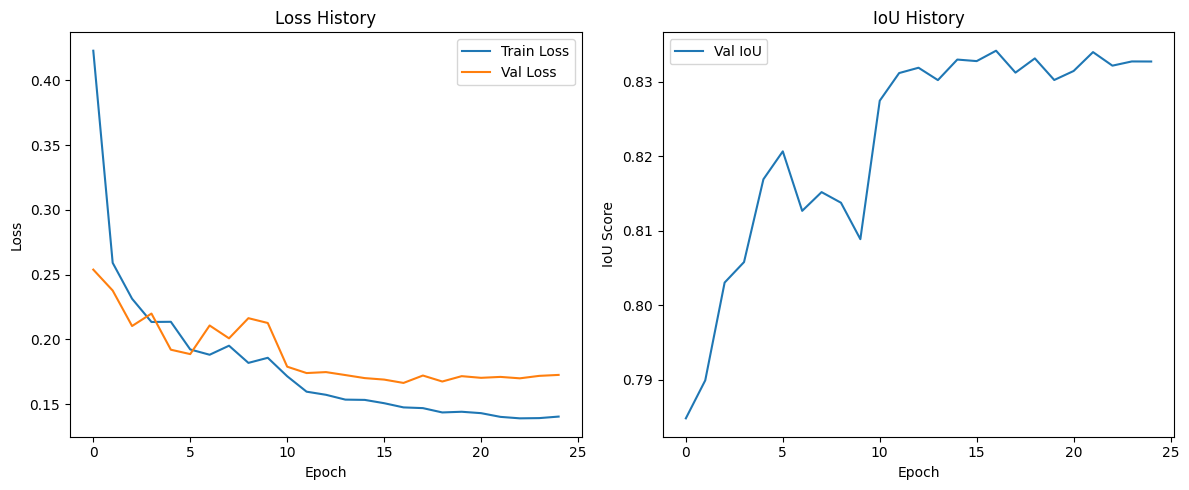

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_iou'], label='Val IoU')
plt.title('IoU History')
plt.xlabel('Epoch')
plt.ylabel('IoU Score')
plt.legend()

plt.tight_layout()
plt.show()